# Image Recognition - Kaggle LEGO Bricks Dataset

## Introduction
In this task we were asked to find an image dataset and perform SIFT detection and create a bag of words model for the images. The word histograms were then used to train and tune k-NN, SVM and Adaboost models and compare the test set performance. This was completed as a group and the table below shows each group members contributions.

## Dataset
For this task we selected the Lego Brick Dataset from Kaggle (https://www.kaggle.com/joosthazelzet/lego-brick-images) The complete dataset contained 16 classes with about 400 images per class totalling approximately 12700 images. 

The dataset consists of consistently sized images taken while a gray Lego brick is slowly rotated. The resulting dataset therefore has many different variations of the same class including various angles and perspectives.

### Base Dataset
The original Kaggle dataset contains approximately 12700 images. This was larger than we needed so we decided to select 4 classes to reduce the size. This left us with about 1600 images (400/class). This was still a bit large, so we further reduced to around 200/class by manually removing images which showed the underside of the brick. This was largely due to simplify the process of reducing the class image count. This resulted in a total of 847 images across all classes (~200/class)

### Pre-Processing
The task requirements stipulate that the images must be varying in resolutions (sizes), viewpoints, lighting conditions, occlusions etc. The Lego Brick dataset images are all consistently sized (200x200) and the same contrast and colour (gray). To fit with the task requirements, a pre-process script was developed and applied to the dataset. 

This pre-processing script selected 50% of the dataset and randomly resized and/or brightened the images using OpenCV. The resized images were randomly scaled down between [0.5, 0.6, 0.7, 0.8]. A random subset were brightened using cv.convertScaleAbs with alpha=1.3 and beta=35.

#### Train / Validation / Test splits.
Once the randomised image transformations were performed, the dataset was then split into train/validation/test sets using the splitfolders python library using ratios (4:3:3). The resulting split of images can be seen below.

<img src="./resources/notebook_imgs/lego_train_test_split.png" alt="Drawing" style="width: 450px;"/>

**Note the below sections are just here to demonstrate the code used. The dataset is already provided in `./resources/lego_dataset/`.**

## Prepare dataset

In [ ]:
import os
import cv2 as cv
import random
import numpy as np
import pandas as pd

import splitfolders

In [ ]:
bricks = ['brick_2x2', 'brick_corner_1x2x2', 'flat_tile_1x2', 'plate_1x1']
path = './4.3_images/'

file_names = []
brick_labels = []


for i in range(0, len(bricks)):
    sub_path = path + bricks[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_brick_labels = [i] * len(sub_file_names)
    file_names += sub_file_names
    brick_labels += sub_brick_labels

All the images in the lego dataset are uniform dimensions and lighting so i change the size and brightness of a random subset of images to get some variation.

In [ ]:
nb_images_to_alter = int(len(file_names)*0.5)

images_to_alter = random.sample(file_names, nb_images_to_alter)
images_to_resize = random.sample(images_to_alter, int(len(file_names)*0.4))
images_to_brighten = random.sample(images_to_alter, int(len(file_names)*0.2))

img_scales = [0.5, 0.6, 0.7, 0.8]

In [ ]:
for file in images_to_resize:
    img = cv.imread(file, cv.IMREAD_UNCHANGED)
    scale_factor = random.sample(img_scales, 1)[0]
    img = cv.resize(img, (0,0), fx=scale_factor, fy=scale_factor)
    cv.imwrite(file, img)

In [ ]:
for file in images_to_brighten:
    img = cv.imread(file, cv.IMREAD_UNCHANGED)
    scale_factor = random.sample(img_scales, 1)[0]
    img = cv.convertScaleAbs(img, alpha=1.3, beta=35)
    cv.imwrite(file, img)

In [ ]:
splitfolders.ratio("./4.3_images/", output="./4.3_images/dataset/", seed=42, ratio=(.4, .3, .3), group_prefix=None)

## Model Build

In [1]:
import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pycm import *

In [2]:
def plot_conf_matrix(data, labels, Title=None):
    plt.figure(figsize=(4,3.5))
    plt.title(Title)
    chart = sns.heatmap(data, cmap='OrRd', square=True,
                        annot=True, linewidths=1, linecolor='white',
                        yticklabels=labels, xticklabels=labels, fmt='.3f',
                        cbar_kws={'fraction' : 0.1})
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    chart.set_yticklabels(chart.get_yticklabels(), rotation=45, horizontalalignment='right')
    plt.show

In [3]:
class Dictionary(object):
    def __init__(self, name, img_filenames, num_words):
        self.name = name #name of your dictionary
        self.img_filenames = img_filenames #list of image filenames
        self.num_words = num_words #the number of words

        self.training_data = [] #this is the training data required by the K-Means algorithm
        self.words = [] #list of words, which are the centroids of clusters

    def learn(self):
        sift = cv.xfeatures2d.SIFT_create()

        num_keypoints = [] #this is used to store the number of keypoints in each image

        #load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    self.training_data.append(des)

        #cluster SIFT descriptors using K-means algorithm
        kmeans = KMeans(self.num_words)
        kmeans.fit(self.training_data)
        self.words = kmeans.cluster_centers_

        #create word histograms for training images
        training_word_histograms = [] #list of word histograms of all training images
        index = 0
        for i in range(0, len(self.img_filenames)):
            #for each file, create a histogram
            histogram = np.zeros(self.num_words, np.float32)
            #if some keypoints exist
            if num_keypoints[i] > 0:
                for j in range(0, num_keypoints[i]):
                    histogram[kmeans.labels_[j + index]] += 1
                index += num_keypoints[i]
                histogram /= num_keypoints[i]
                training_word_histograms.append(histogram)

        return training_word_histograms

    def create_word_histograms(self, img_filenames):
        sift = cv.xfeatures2d.SIFT_create()
        histograms = []

        for filename in img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            descriptors = sift.detectAndCompute(img_gray, None)[1]

            histogram = np.zeros(self.num_words, np.float32) #word histogram for the input image

            if descriptors is not None:
                for des in descriptors:
                    #find the best matching word
                    min_distance = 1111111 #this can be any large number
                    matching_word_ID = -1 #initial matching_word_ID=-1 means no matching

                    for i in range(0, self.num_words): #search for the best matching word
                        distance = np.linalg.norm(des - self.words[i])
                        if distance < min_distance:
                            min_distance = distance
                            matching_word_ID = i

                    histogram[matching_word_ID] += 1

                histogram /= len(descriptors) #normalise histogram to frequencies

            histograms.append(histogram)

        return histograms

In [4]:
import os

bricks = ['brick_2x2', 'brick_corner_1x2x2', 'flat_tile_1x2', 'plate_1x1']
path = './resources/lego_dataset/'

training_file_names = []
training_labels = []

test_file_names = []
test_labels = []

val_file_names = []
val_labels = []


for i in range(0, len(bricks)):
    sub_path = path + 'train/' + bricks[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_labels = [i] * len(sub_file_names)
    training_file_names += sub_file_names
    training_labels += sub_labels
    
for i in range(0, len(bricks)):
    sub_path = path + 'test/' + bricks[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_labels = [i] * len(sub_file_names)
    test_file_names += sub_file_names
    test_labels += sub_labels
    
for i in range(0, len(bricks)):
    sub_path = path + 'val/' + bricks[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_labels = [i] * len(sub_file_names)
    val_file_names += sub_file_names
    val_labels += sub_labels

## Selecting the right k-value for the BoW model

The bag of Words model requires a k parameter for the number of words to use as part of the underlying k-means model. To select the best k value, we applied the elbow method whereby a range of k values are used iteratively, and the results plotted. A range of 10 – 200 with a step size of 10.

The optimal value identified by the “elbow” or kink in the chart was hard to identify. We decided to run 2 experiments with k=50 and k=125 against the validation set and see which one produced better results. The k=125 resulted in the better performing model across all 3 so the rest of the task was completed using this k-value. The resulting plot can be seen below.

In [5]:
num_keypoints = []
training_data = []

sift = cv.xfeatures2d.SIFT_create()

for filename in training_file_names:
        img = cv.imread(filename)
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        list_des = sift.detectAndCompute(img_gray, None)[1]
        if list_des is None:
            num_keypoints.append(0)
        else:
            num_keypoints.append(len(list_des))
            for des in list_des:
                training_data.append(des)

In [ ]:
sse = []
list_k = list(range(10, 200,10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(training_data)
    sse.append(km.inertia_)

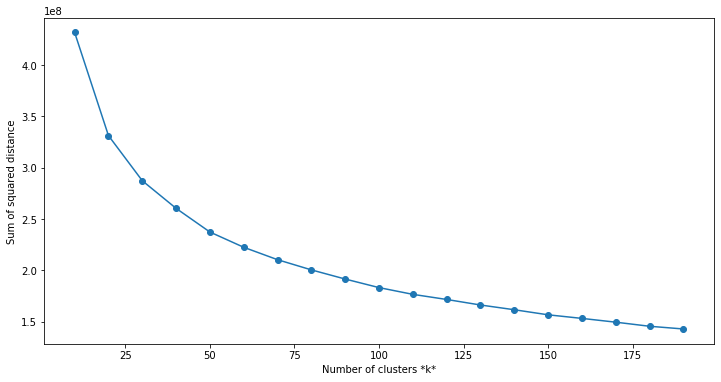

In [68]:
# Plot sse against k
plt.figure(figsize=(12, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

## Build the BoW model and get the word historgrams

In [49]:
num_words = 125
dictionary_name = 'bricks'
dictionary = Dictionary(dictionary_name, training_file_names, num_words)

In [50]:
training_word_histograms = dictionary.learn()

In [9]:
import pickle

with open('brick_dictionary.dic', 'wb') as f:
    pickle.dump(dictionary, f)

In [10]:
with open('brick_dictionary.dic', 'rb') as f: #'rb' is for binary read
    dictionary = pickle.load(f)

In [51]:
test_word_histograms = dictionary.create_word_histograms(test_file_names)
validation_word_histograms = dictionary.create_word_histograms(val_file_names)

## 2. k-NN Optimisation

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

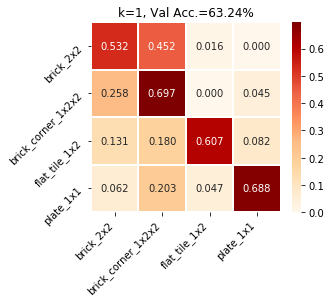

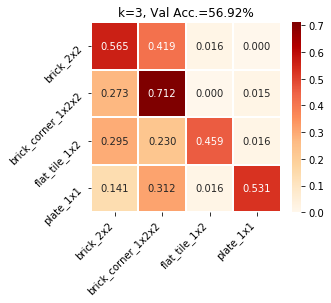

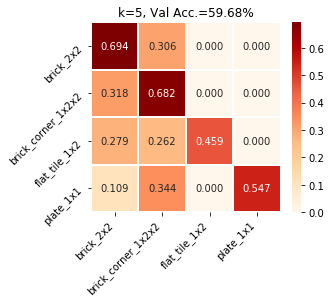

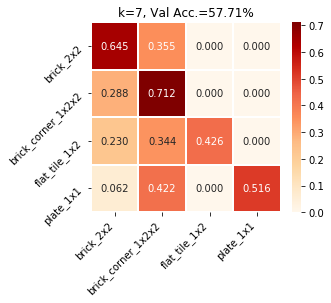

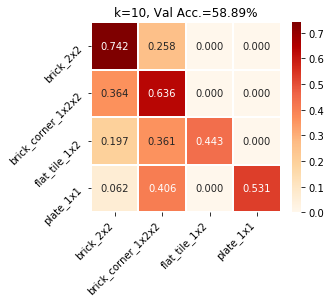

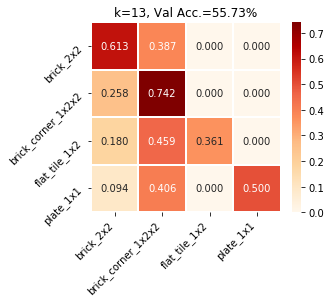

In [54]:
ks =  [1, 3, 5, 7, 10, 13]

for k in ks:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(training_word_histograms, training_labels)
    predicted_labels = knn.predict(validation_word_histograms)
    cm = confusion_matrix(val_labels, predicted_labels, normalize='true')
    plot_conf_matrix(cm, bricks, f'k={k}, Val Acc.={accuracy_score(val_labels, predicted_labels)*100:.2f}%')

The k-NN model’s primary parameter is the k-value. To determine the best value, we trained models using: [1, 3, 5, 7, 10, 13] and then plotted the accuracy and confusion matrix using the validation set. The results can be seen in above. The best performance was achieved with k=1.

## K-NN Test set

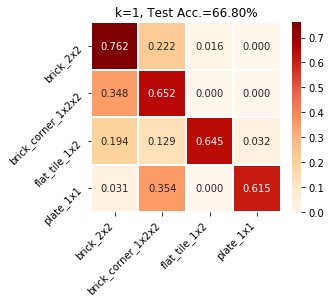

In [55]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(training_word_histograms, training_labels)
predicted_labels = knn.predict(test_word_histograms)
cm = confusion_matrix(test_labels, predicted_labels, normalize='true')
plot_conf_matrix(cm, bricks, f'k={1}, Test Acc.={accuracy_score(test_labels, predicted_labels)*100:.2f}%')

## 3. SVM optimisation

In [56]:
from sklearn import svm

In [57]:
cs = [10, 20, 30, 40, 50, 75]

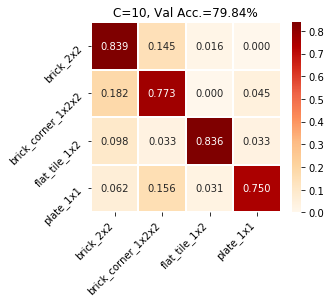

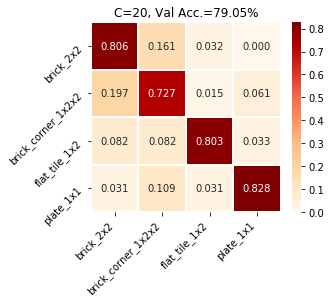

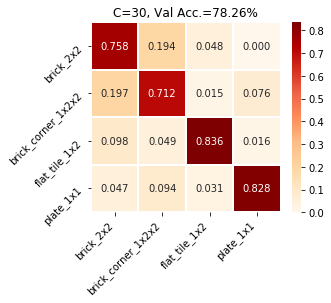

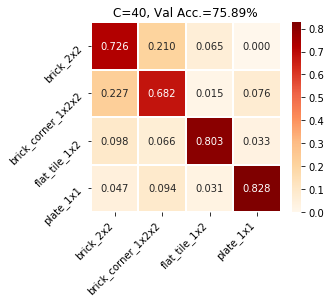

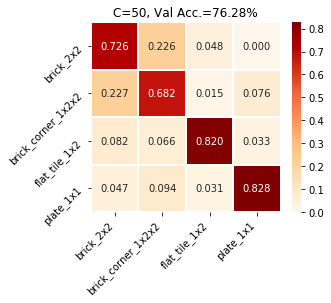

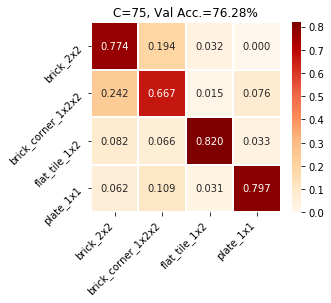

In [58]:
for c in cs:
    svm_classifier = svm.SVC(C = c,
                         kernel = 'linear', random_state=42)
    svm_classifier.fit(training_word_histograms, training_labels)
    predicted_labels = svm_classifier.predict(validation_word_histograms)
    cm = confusion_matrix(val_labels, predicted_labels, normalize='true')
    plot_conf_matrix(cm, bricks, f'C={c}, Val Acc.={accuracy_score(val_labels, predicted_labels)*100:.2f}%')

The SVM model’s primary parameter is the C-value. To determine the best value, we trained models using: [10, 20, 30, 40, 50, 75] and then plotted the accuracy and confusion matrix using the validation set. The results can be seen in above. The best performance was achieved with C=40.

## SVM Test set

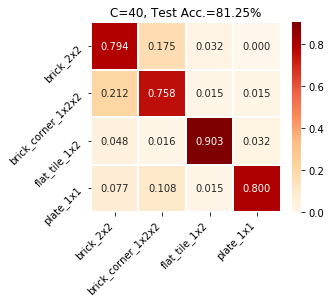

In [59]:
svm_classifier = svm.SVC(C = 30,
                     kernel = 'linear', random_state=42)
svm_classifier.fit(training_word_histograms, training_labels)
predicted_labels = svm_classifier.predict(test_word_histograms)
cm = confusion_matrix(test_labels, predicted_labels, normalize='true')
plot_conf_matrix(cm, bricks, f'C={40}, Test Acc.={accuracy_score(test_labels, predicted_labels)*100:.2f}%')

## 4.. AdaBoost Optimisation

In [60]:
from sklearn.ensemble import AdaBoostClassifier

In [61]:
n_estmators =  [150, 200, 250, 300, 400, 500]

Validation testing parameters

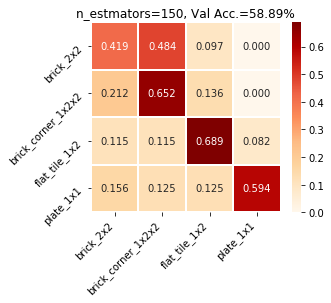

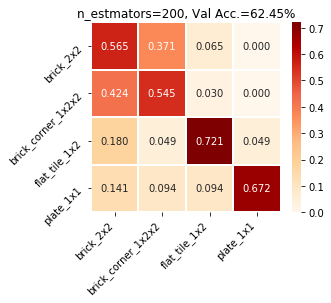

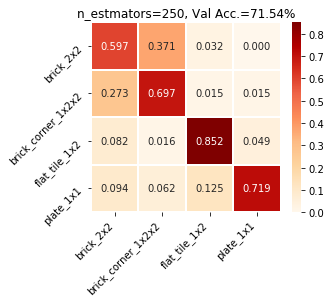

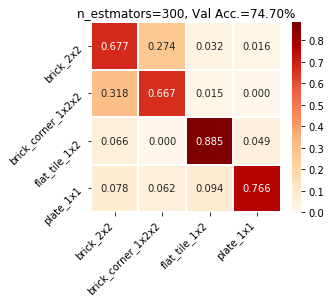

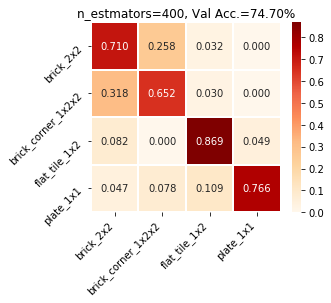

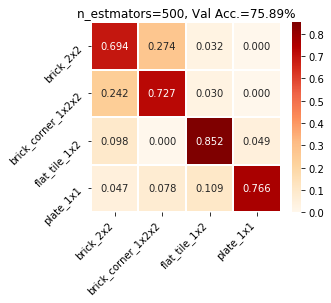

In [62]:
for n in n_estmators:
    adb_classifier = AdaBoostClassifier(n_estimators = n,
                                        random_state = 42)

    adb_classifier.fit(training_word_histograms, training_labels)
    predicted_labels = adb_classifier.predict(validation_word_histograms)
    cm = confusion_matrix(val_labels, predicted_labels, normalize='true')
    plot_conf_matrix(cm, bricks, f'n_estmators={n}, Val Acc.={accuracy_score(val_labels, predicted_labels)*100:.2f}%')

The Adaboost model’s primary parameter is the n_estimators. To determine the best value, we trained models using: [150, 200, 250, 300, 400, 500] and then plotted the accuracy and confusion matrix using the validation set. The results can be seen above. The best performance was achieved with `n_estimators=500`.

## AdaBoost Test set

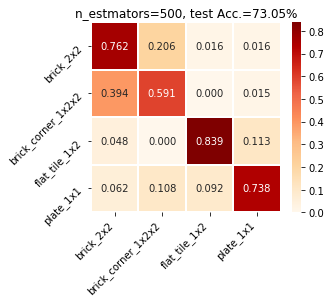

In [63]:
adb_classifier = AdaBoostClassifier(n_estimators = 500,
                                    random_state = 42)

adb_classifier.fit(training_word_histograms, training_labels)
predicted_labels = adb_classifier.predict(test_word_histograms)
cm = confusion_matrix(test_labels, predicted_labels, normalize='true')
plot_conf_matrix(cm, bricks, f'n_estmators={500}, test Acc.={accuracy_score(test_labels, predicted_labels)*100:.2f}%')

## Benchmarking Results

The optimal parameters determined using the validation set were used to build models and score using the test set. The validation vs test set accuracies were closest for the SVM model. The k-NN and AdaBoost models performed better on the test set.

The confusion matrix plots shown in table 9 indicated that the k-NN model was the least accurate and was often confusing classes brick_2x2 and brick_corner_1x2x2. This is not surprising as when you compare some of the images below you can see how the confusion would occur. 

brick_2x2 | brick_corner_1x2x2 |
- | - |
![alt](./resources/notebook_imgs/block1.png) | ![alt](./resources/notebook_imgs/block2.png)|

The other classes were more distinct in share and size and resulted in less confusion. Overall, the AdaBoost model performed the best with a test set accuracy of 81.25% followed closely by the SVM at 80.86%. The k-NN performed significantly worse achieving only 65.62%. The validation vs test accuracies are summarised in the table below.

Model | Validation Acc. | Test Acc
- | - | -
k-NN (k=1)|61.26%| 65.62%
SVM (C=40)|81.03%|80.86%
AdaBoost (n_estimators=500)|76.28%|81.25%
